# Example: Plume Estimates from Velocity Data

Set the backend of matplotlib to the 'inline' backend (specific for Jupyter notebooks) so that result of all plotting commands is displayed inline directly below the code cell that produces it.

In [1]:
 %matplotlib inline

#### Import the standard and third party Python libraries.

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, os.sep.join(['..', '..', 'source']))
from openiam import SystemModel

sys.path.insert(0, os.sep.join(['..', '..', 'ramp']))
from ramp.data_container import DataContainer, default_bin_file_reader
from ramp.plume_estimate import PlumeEstimate

#### Setup arguments of system model.

In [3]:
# Define keyword arguments of the system model
final_year = 200
num_intervals = (final_year-10)//10
time_array = 365.25*np.linspace(10.0, final_year, num=num_intervals+1)
sm_model_kwargs = {'time_array': time_array}   # time is given in days

#### Setup arguments of data container.

In [4]:
# Observation name
obs_name = 'velocity'

# Path to the data files
data_directory = os.path.join('..', '..', 'data', 'user', 'velocity')
output_directory = os.path.join('..', '..', 'examples', 'user', 'output',
                                'ramp_sys_plume_estimate_multiple_scenarios')
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
# Data reader to be used to read data files
data_reader = default_bin_file_reader

# Keyword arguments for reader specifying expected data shape and reformatting needed
data_reader_kwargs = {'data_shape': (141, 401),
                      'move_axis_destination': [-1, -2]}

# Time points at which data is available, in years
time_points = np.linspace(10.0, final_year, num=num_intervals+1)
num_time_points = len(time_points)

# Select scenarios to link to the data container
scenarios = [12, 109, 622, 141, 318, 881, 986, 22, 76, 269]
num_scenarios = len(scenarios)

# Data family
family = 'velocity'

# Setup dictionary needed for data container setup
data_setup = {}
for ind in scenarios:
    data_setup[ind] = {'folder': os.path.join('vp_sim{:04}'.format(ind), 'model')}
    for t_ind in range(1, num_time_points+1):
        data_setup[ind]['t{}'.format(t_ind)] = 'model_sim{:04}_t{}.bin'.format(ind, t_ind*10)
        
# baseline is True if data is supposed to have baseline data
baseline = True

#### Print summary of available data.

In [5]:
print('Type of data:', family)
print('Number of available scenarios:', num_scenarios)
print('Scenarios to be analyzed:', scenarios)
print('Years at which data is analyzed:', time_points)
print('Expected data shape:', (401, 141), '= (n_x x n_z)')

Type of data: velocity
Number of available scenarios: 10
Scenarios to be analyzed: [12, 109, 622, 141, 318, 881, 986, 22, 76, 269]
Years at which data is analyzed: [ 10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140.
 150. 160. 170. 180. 190. 200.]
Expected data shape: (401, 141) = (n_x x n_z)


#### Create System Model.

In [6]:
# Create system model
sm = SystemModel(model_kwargs=sm_model_kwargs)

#### Create and setup Data Container.
Data Container reads data from linked data files and output produced data for other components to use.

In [7]:
dc = sm.add_component_model_object(
        DataContainer(name='dc', parent=sm, family=family, obs_name=obs_name,
                      data_directory=data_directory, data_setup=data_setup,
                      time_points=time_points, baseline=baseline,
                      data_reader=data_reader,
                      data_reader_kwargs=data_reader_kwargs,
                      presetup=True)) # attribute linkobs is populated

# Add parameters of the container
dc.add_par('index', value=scenarios[0],
           discrete_vals=[scenarios, num_scenarios*[1/num_scenarios]])

# Add gridded observations
# Observation added is 'velocity'
dc.add_grid_obs(obs_name, constr_type='matrix', output_dir=output_directory)
# Observation added is 'delta_velocity'
dc.add_grid_obs('delta_{}'.format(obs_name), constr_type='matrix',
                output_dir=output_directory)
# Observation added is 'baseline_velocity'
dc.add_grid_obs('baseline_{}'.format(obs_name), constr_type='matrix',
                output_dir=output_directory)

#### Create and setup Plume Estimate.
Plume Estimate component inputs velocity data from the Data Container, performs some data processing and returns plume extent and locations.

In [8]:
# Setup x- and z-coordinates associated with data
coordinates = {1: 4000 + 10*np.arange(401),
               2: 10*np.arange(141)}  # 1 is x, 2 is z

# Add plume estimate component
plest = sm.add_component_model_object(
    PlumeEstimate(name='plest', parent=sm, coordinates=coordinates, size=100,
                  criteria=3))  # criteria = 3 means compare ratio to threshold

# Add keyword arguments linked to the data container outputs
# Observation linked to 'data' is 'velocity'
plest.add_kwarg_linked_to_obs('data', dc.linkobs[obs_name], obs_type='grid')
# Observation linked to 'baseline' i 'baseline_velocity'
plest.add_kwarg_linked_to_obs('baseline', dc.linkobs['baseline_{}'.format(obs_name)],
                              obs_type='grid')

# Add threshold parameter
plest.add_par('threshold', value=5.0, vary=False)  # 5%

# Add gridded observations
# "plume" observation is 0's and 1's
plest.add_grid_obs('plume', constr_type='matrix', output_dir=output_directory)
# "plume_data" observation is data that was compared to threshold to produce
# "plume" observation. For criteria 3 it's a ratio of change in data over baseline data
# multiplied by 100 to get a percentage
plest.add_grid_obs('plume_data', constr_type='matrix', output_dir=output_directory)

# Add gridded observations related to each dimension
# mins are leftmost x- and z-coordinates of the plume
# maxs are rightmost x- and z-coordinates of the plume
# extents are lengths of the plume in each direction
for nm in ['min1', 'min2', 'max1', 'max2', 'extent1', 'extent2', 'plume_size']:
    plest.add_grid_obs(nm, constr_type='array', output_dir=output_directory)
    
# Add scalar observation
plest.add_obs('num_plumes')

#### Run model as stochastic.

In [9]:
# Create sampleset varying over scenarios
samples = np.array(scenarios).reshape(num_scenarios, 1)
s = sm.create_sampleset(samples)

# Run sampleset
results = s.run(cpus=4, verbose=False)

#### Get selected data from saved files or directly from System Model.

In [10]:
# Get scalar observations
out = s.collect_observations_as_time_series()
# Get gridded observations from saved files
time_indices = list(range(num_time_points))
velocity = {}
plume = {}
plume_data = {}
plume_metrics = {}
for obs in ['min1', 'min2', 'max1', 'max2', 'extent1', 'extent2']:
    plume_metrics[obs] = {}
for rlzn_number, scen in enumerate(scenarios):
    print('Loading data for scenario {}...'.format(scen))
    velocity[scen] = sm.collect_gridded_observations_as_time_series(
        dc, 'velocity', output_directory,
        indices=time_indices, rlzn_number=rlzn_number+1)
    plume[scen] = sm.collect_gridded_observations_as_time_series(
        plest, 'plume', output_directory,
        indices=time_indices, rlzn_number=rlzn_number+1)
    plume_data[scen] = sm.collect_gridded_observations_as_time_series(
        plest, 'plume_data', output_directory,
        indices=time_indices, rlzn_number=rlzn_number+1)
    for obs in ['min1', 'min2', 'max1', 'max2', 'extent1', 'extent2']:
        plume_metrics[obs][scen] = sm.collect_gridded_observations_as_time_series(
            plest, obs, output_directory, indices=time_indices, rlzn_number=rlzn_number+1) 

Loading data for scenario 12...
Loading data for scenario 109...
Loading data for scenario 622...
Loading data for scenario 141...
Loading data for scenario 318...
Loading data for scenario 881...
Loading data for scenario 986...
Loading data for scenario 22...
Loading data for scenario 76...
Loading data for scenario 269...


#### Print results.

In [11]:
# Print largest plume for each scenario
print(83*'-')
header_to_print = '  |  '.join([
    '|  Scenario', 'time', 'xextent', 'zextent', 'xmin', 'xmax', 'zmin', 'zmax  |'])
line_to_print = ' | '.join(['| {: >9} ', '{: >6}', '{: >8} ', '{: >8} ',
                            '{: >6}', '{: >6}', '{: >6}', '{: >6} |'])
for scen_ind, scen in enumerate(scenarios):
    print(header_to_print)
    print(83*'-')
    for ind in range(num_time_points):
        print(line_to_print.format(
            scen, time_points[ind],
            plume_metrics['extent1'][scen][ind][0],
            plume_metrics['extent2'][scen][ind][0],
            plume_metrics['min1'][scen][ind][0],
            plume_metrics['max1'][scen][ind][0],
            plume_metrics['min2'][scen][ind][0],
            plume_metrics['max2'][scen][ind][0]))
    print(83*'-')

-----------------------------------------------------------------------------------
|  Scenario  |  time  |  xextent  |  zextent  |  xmin  |  xmax  |  zmin  |  zmax  |
-----------------------------------------------------------------------------------
|        12  |   10.0 |      0.0  |      0.0  | -999.0 | -999.0 | -999.0 | -999.0 |
|        12  |   20.0 |      0.0  |      0.0  | -999.0 | -999.0 | -999.0 | -999.0 |
|        12  |   30.0 |      0.0  |      0.0  | -999.0 | -999.0 | -999.0 | -999.0 |
|        12  |   40.0 |      0.0  |      0.0  | -999.0 | -999.0 | -999.0 | -999.0 |
|        12  |   50.0 |     30.0  |     80.0  | 5040.0 | 5070.0 |  660.0 |  740.0 |
|        12  |   60.0 |     70.0  |    140.0  | 5020.0 | 5090.0 |  660.0 |  800.0 |
|        12  |   70.0 |     90.0  |    180.0  | 5010.0 | 5100.0 |  650.0 |  830.0 |
|        12  |   80.0 |    100.0  |    200.0  | 5010.0 | 5110.0 |  650.0 |  850.0 |
|        12  |   90.0 |    120.0  |    210.0  | 5000.0 | 5120.0 |  650.0 |  

#### Plot results.

##### Velocity data

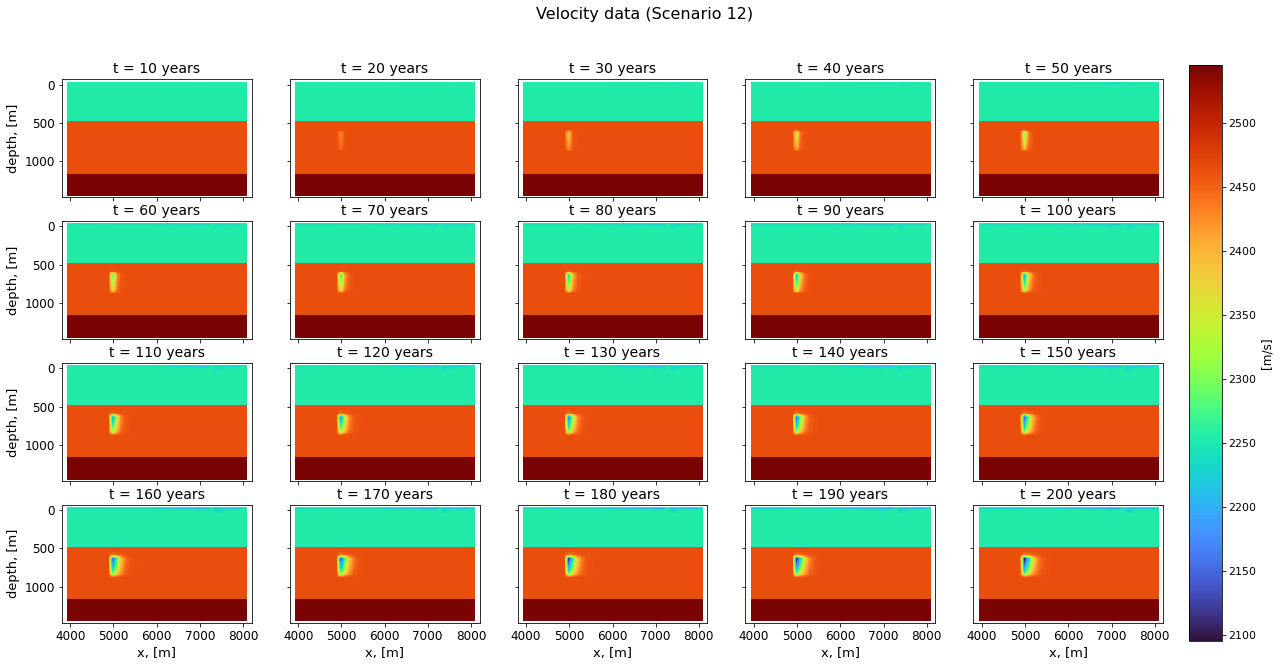

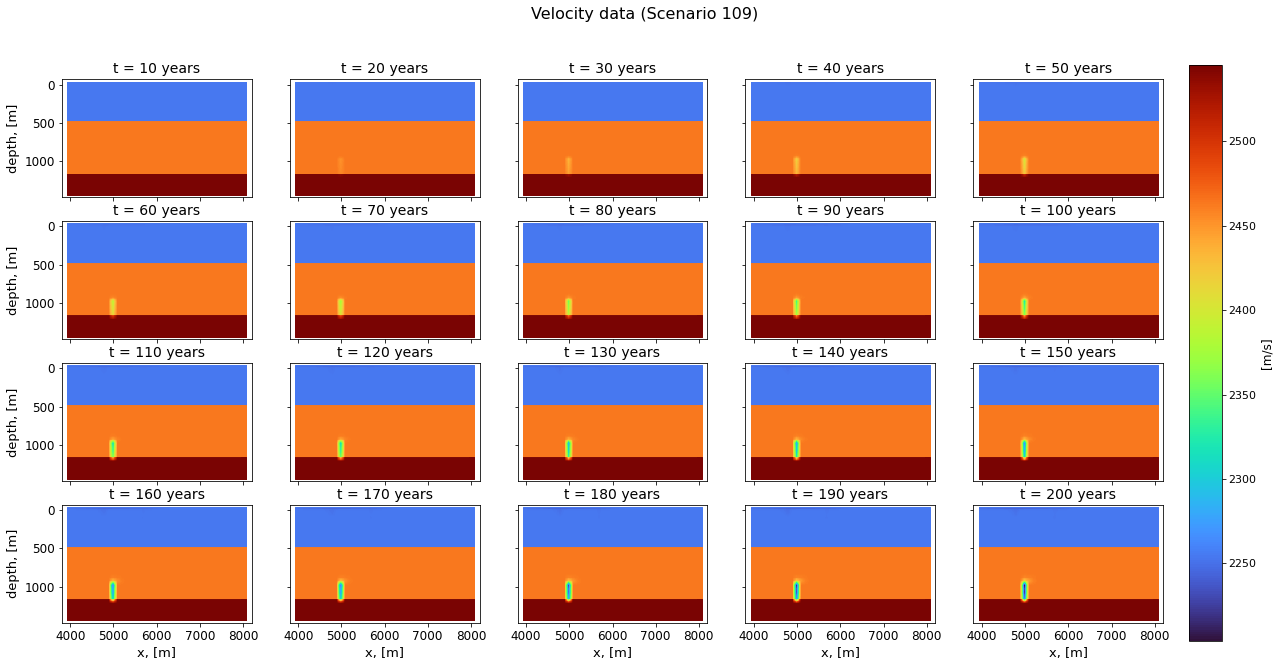

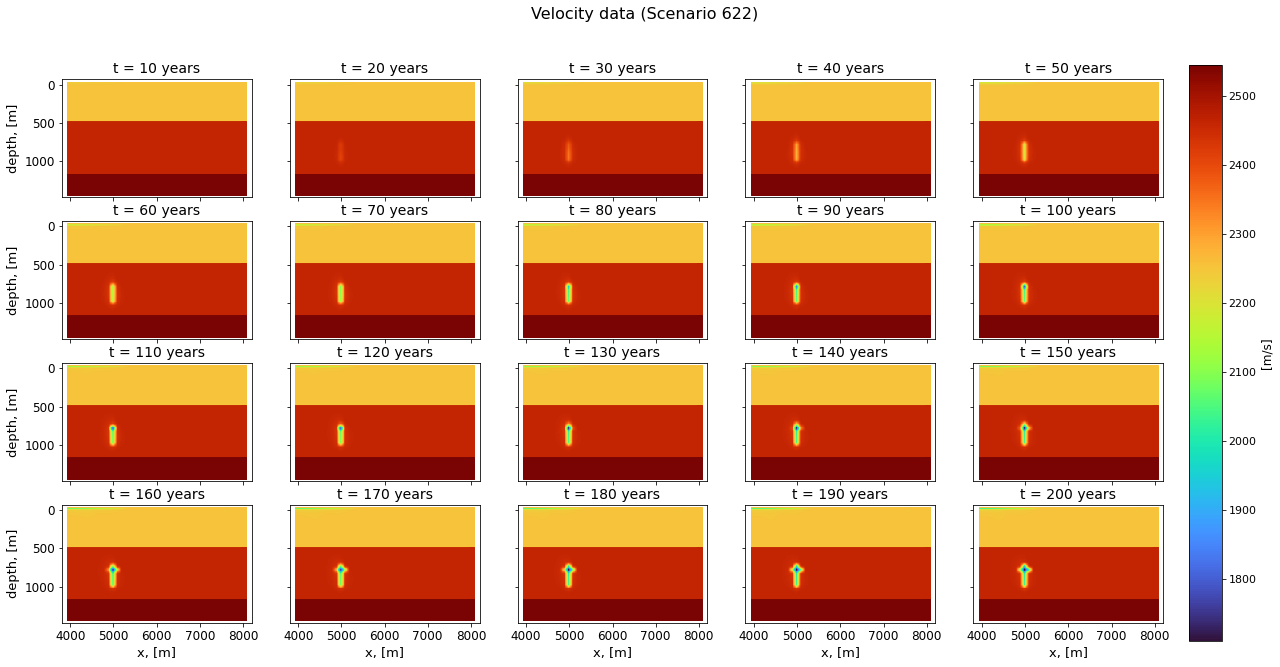

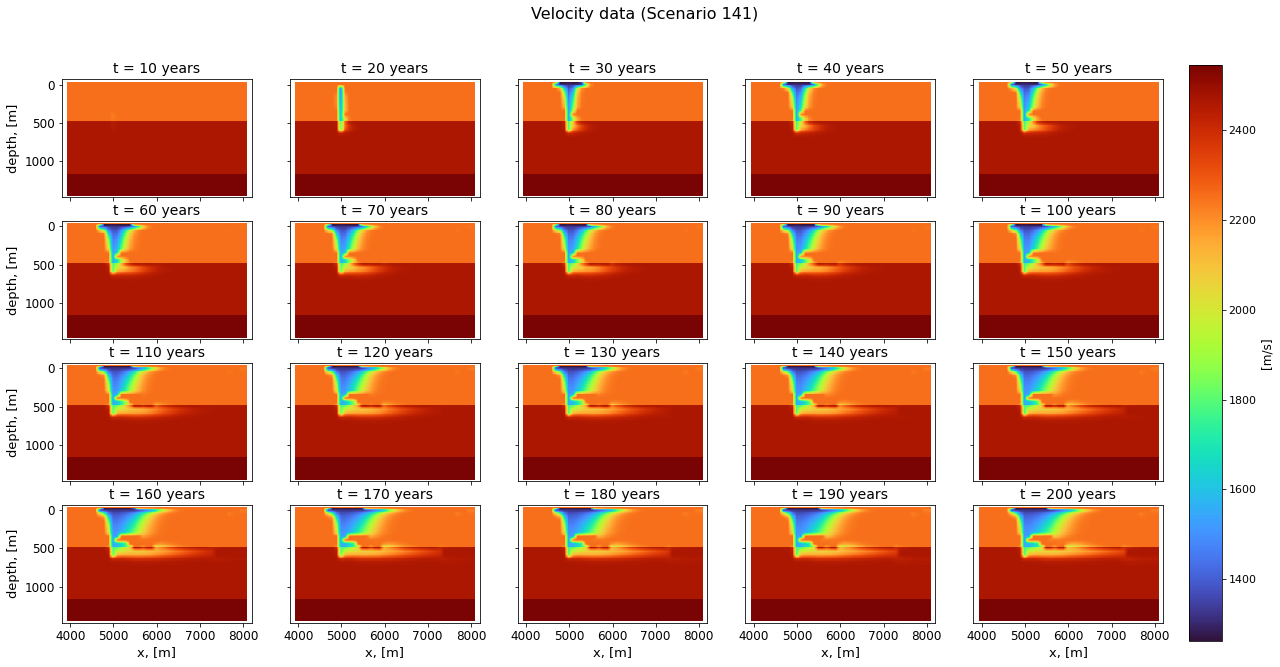

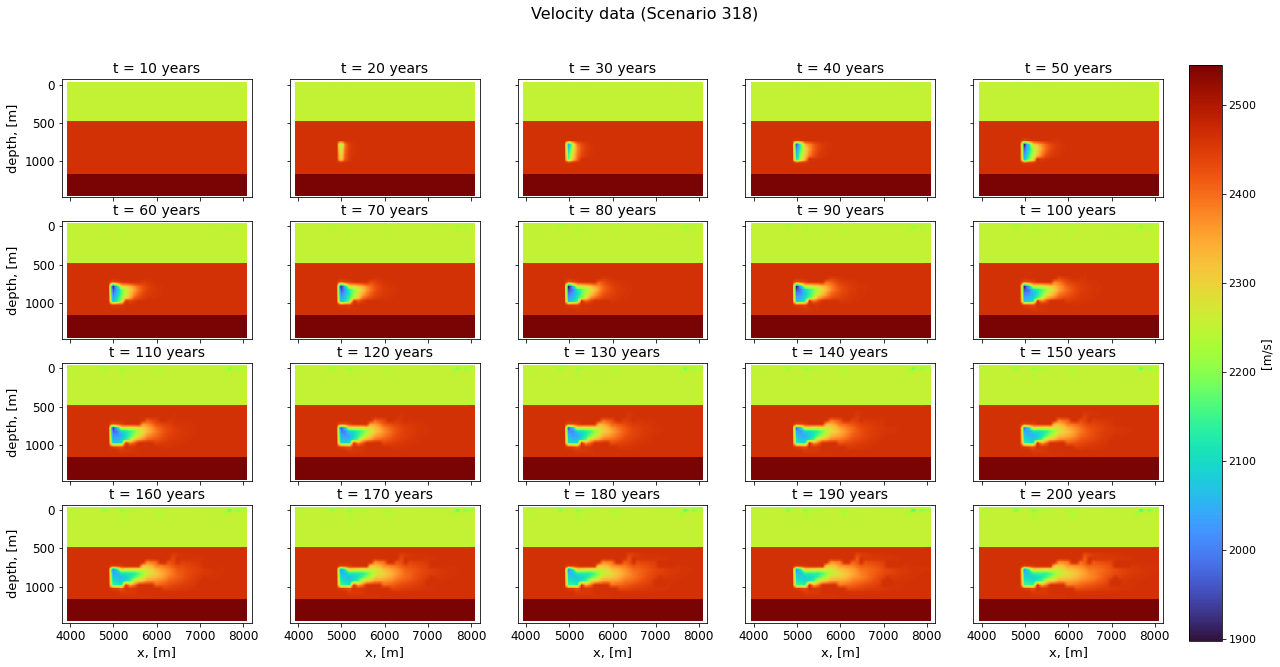

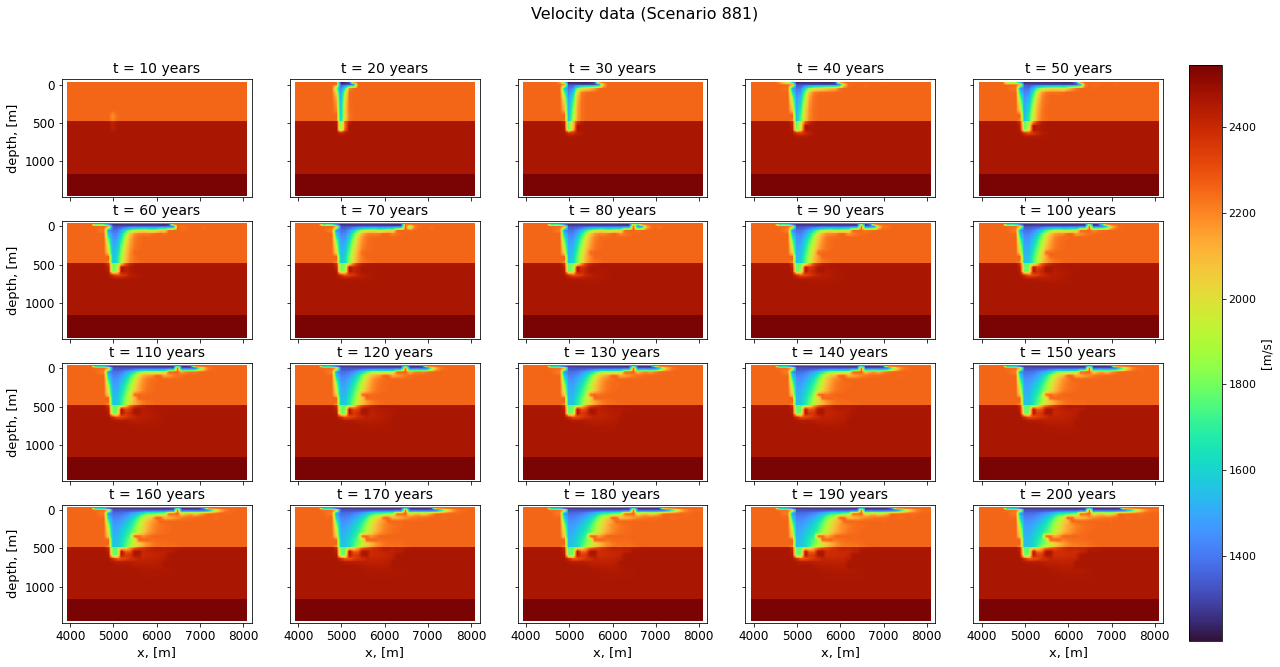

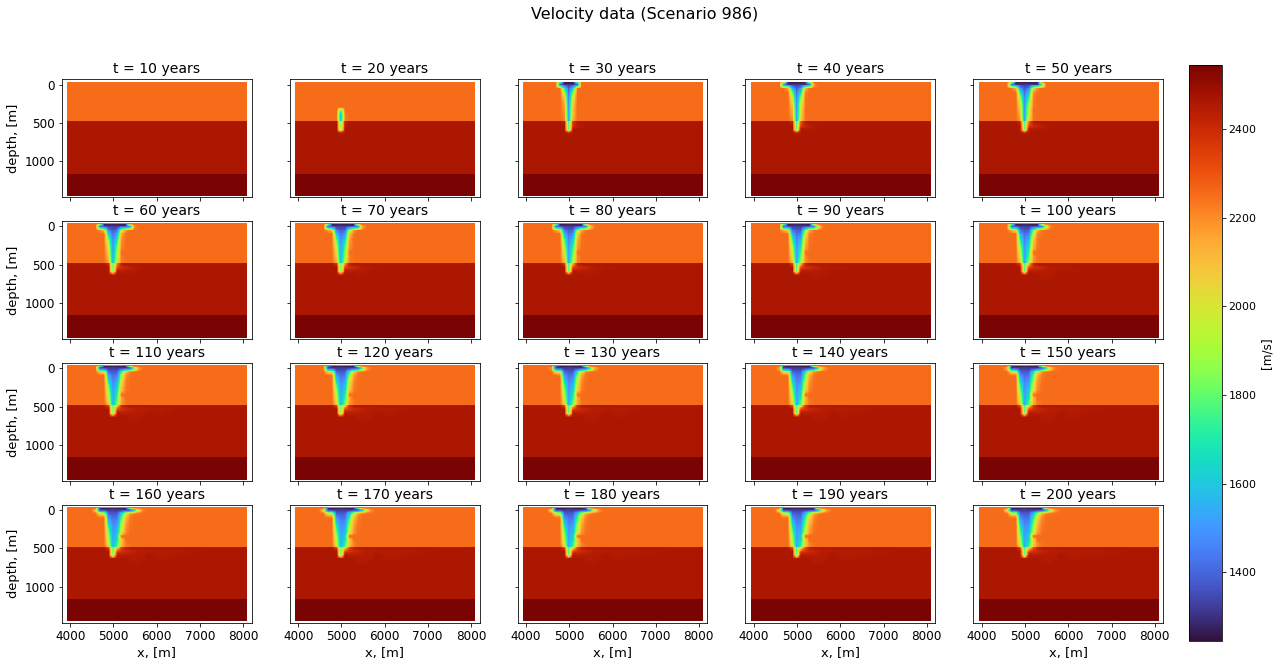

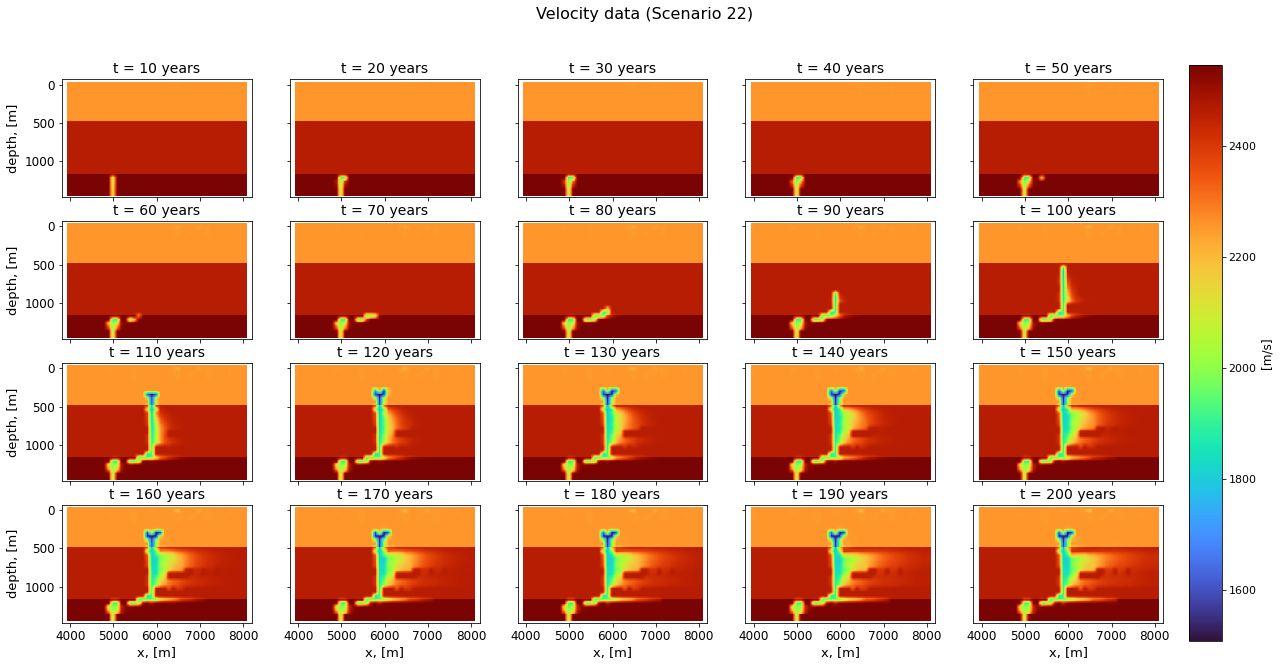

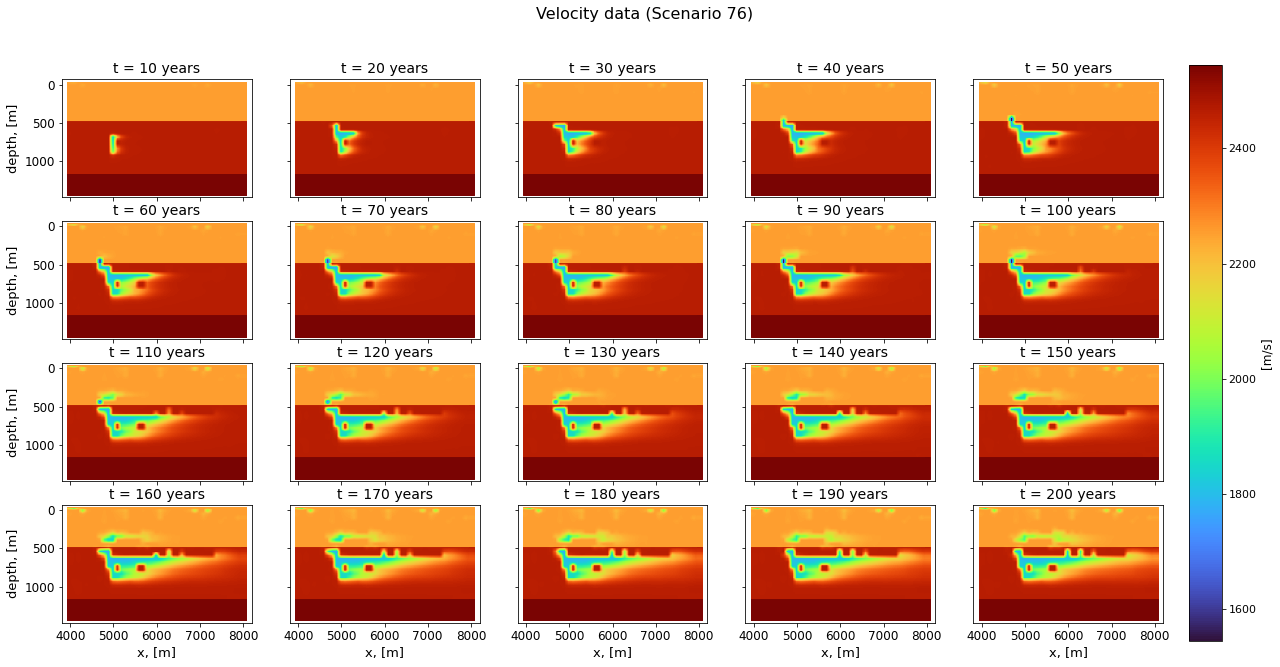

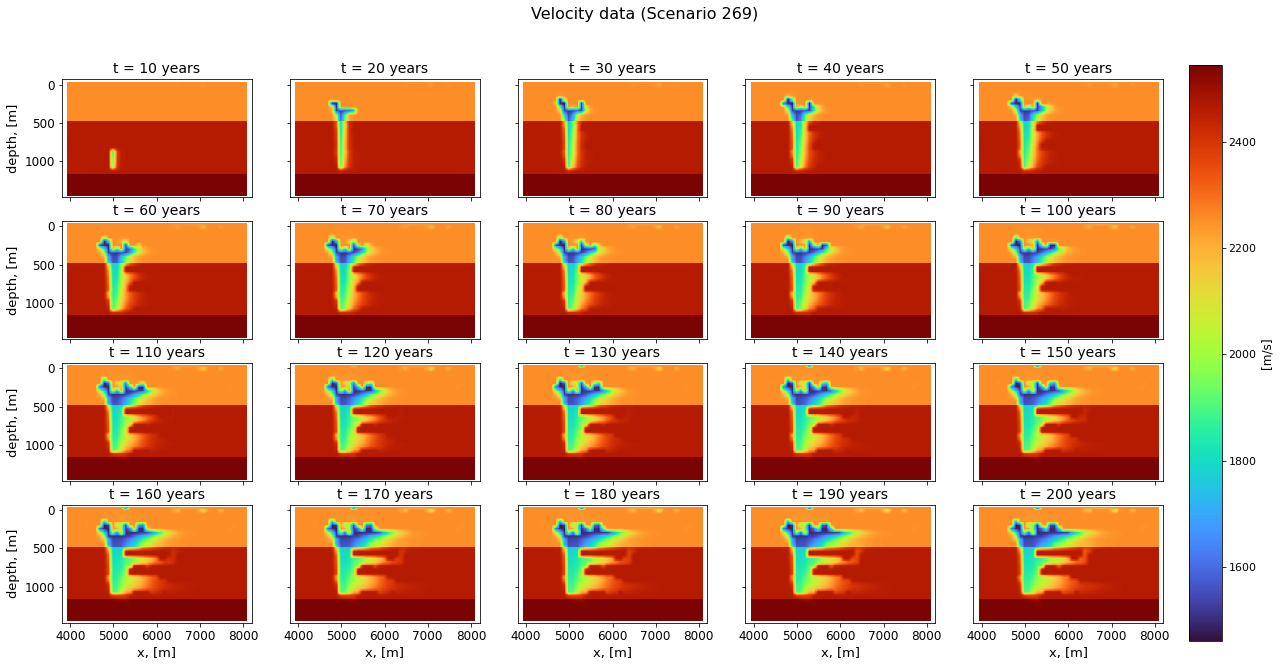

In [12]:
xs = coordinates[1]
zs = coordinates[2]

xxs, zzs = np.meshgrid(xs, zs, indexing='ij')
labelsize = 12
for scen in scenarios:
    fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(18, 10),
                            sharex=True, sharey=True)
    vmin = np.min(velocity[scen])
    vmax = np.max(velocity[scen])
    for ind in range(num_time_points):
        row = ind//5
        col = ind%5
        pic = axs[row, col].scatter(xxs, zzs, c=velocity[scen][ind],
                              cmap='turbo', marker='s',
                              vmin=vmin, vmax=vmax)
        axs[row, col].set_title('t = {} years'.format((ind+1)*10),
                                fontsize=labelsize+2)
        axs[row, col].tick_params(axis='both', which='major',
                                  labelsize=labelsize)
    axs[0, 0].invert_yaxis()
    for row in range(4):
        axs[row, 0].set_ylabel('depth, [m]', fontsize=labelsize+1)
    for col in range(5):
        axs[3, col].set_xlabel('x, [m]', fontsize=labelsize+1)
    fig.suptitle('Velocity data (Scenario {})'.format(scen),
                 fontsize=labelsize+4)
    fig.subplots_adjust(left=0.05, right=0.9)
    cax = plt.axes([0.92, 0.1, 0.025, 0.8])
    cbar = fig.colorbar(pic, ax=axs, cax=cax)
    cbar.ax.tick_params(labelsize=labelsize-1)
    cbar.set_label(label='[m/s]', size=labelsize)

##### Plume data

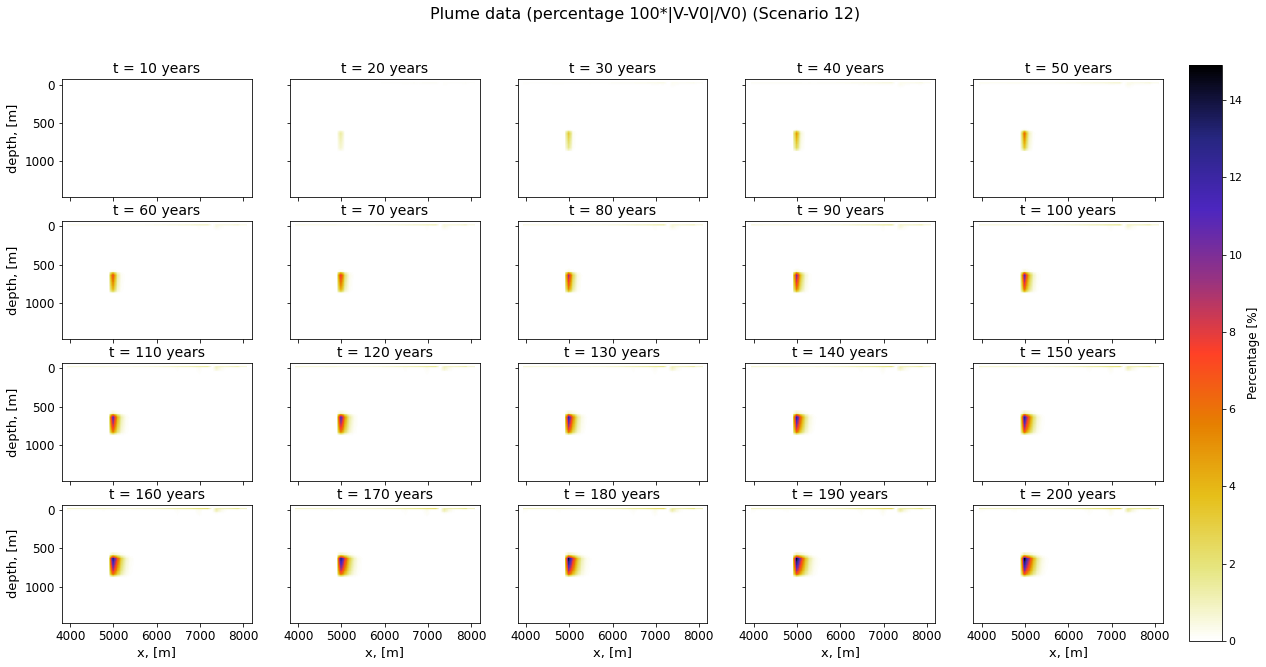

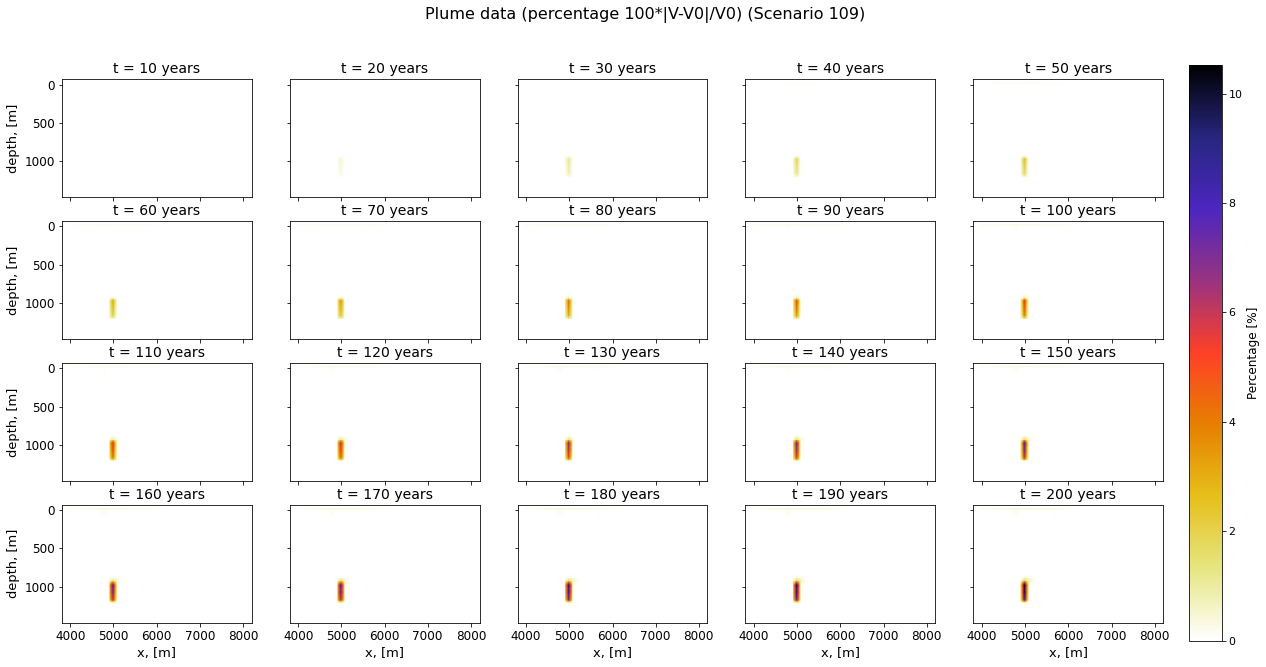

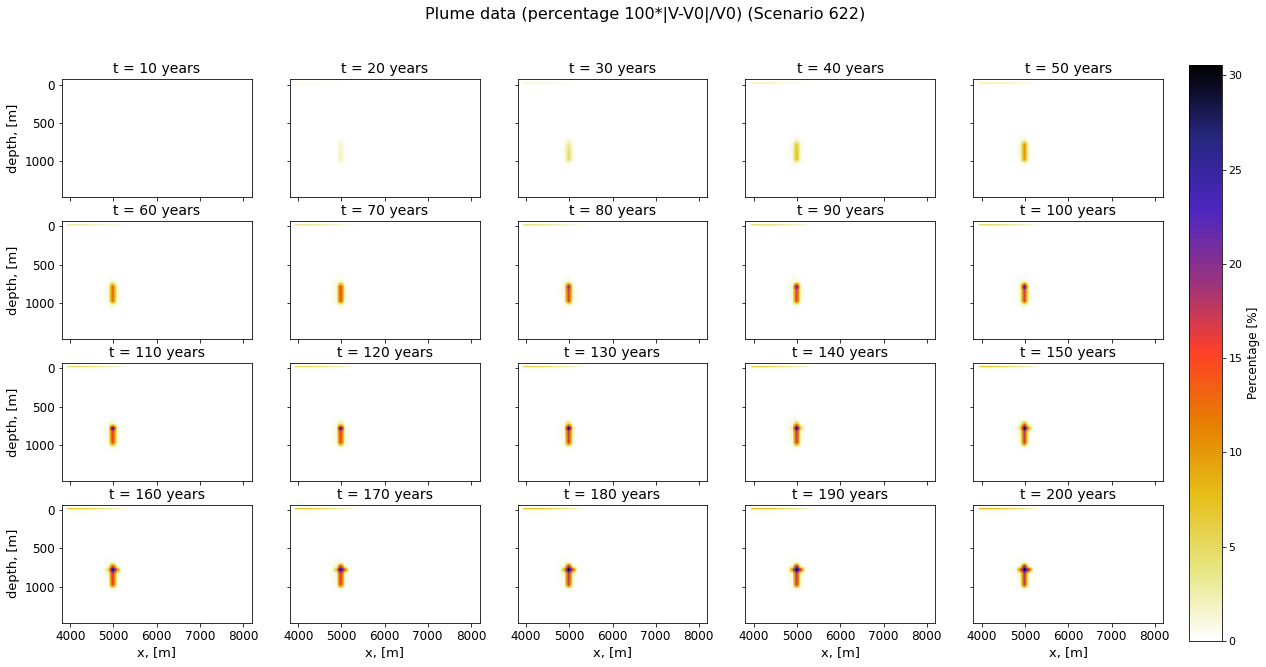

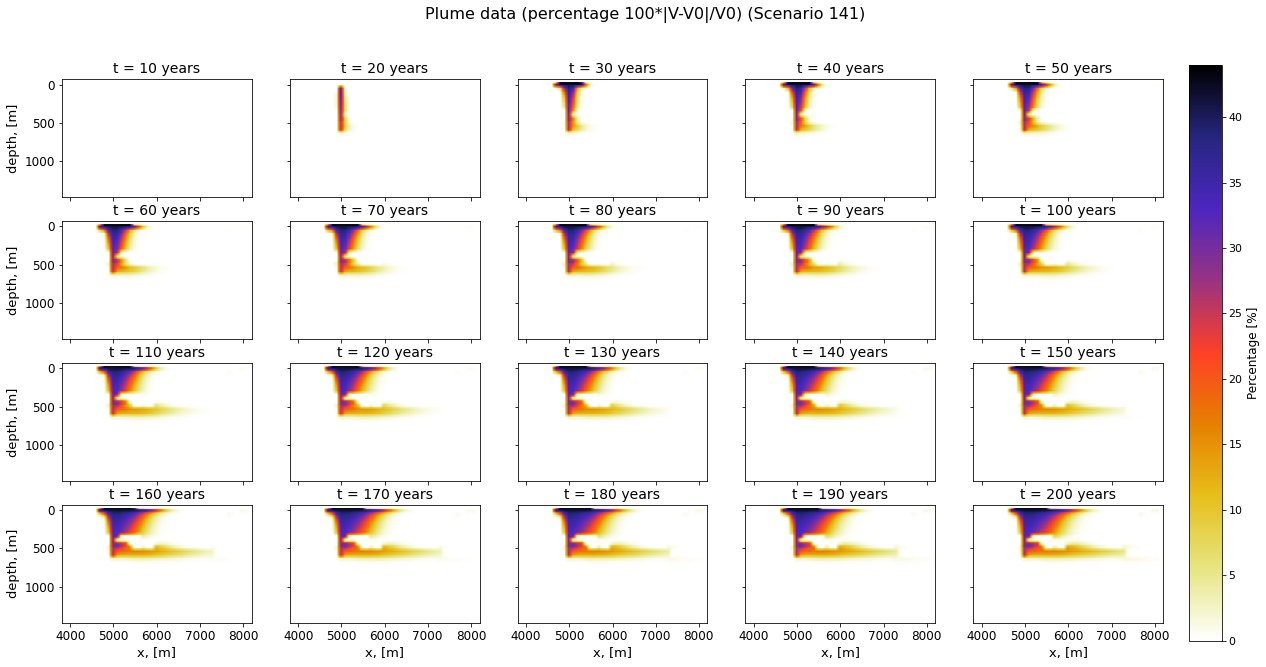

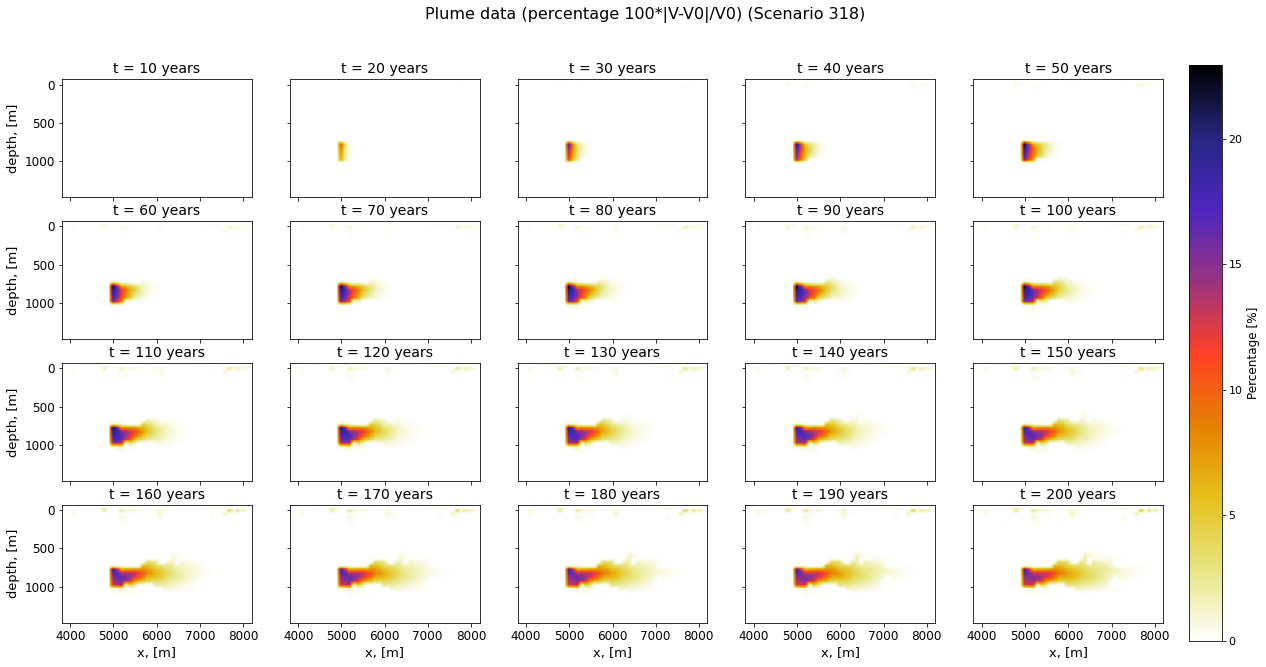

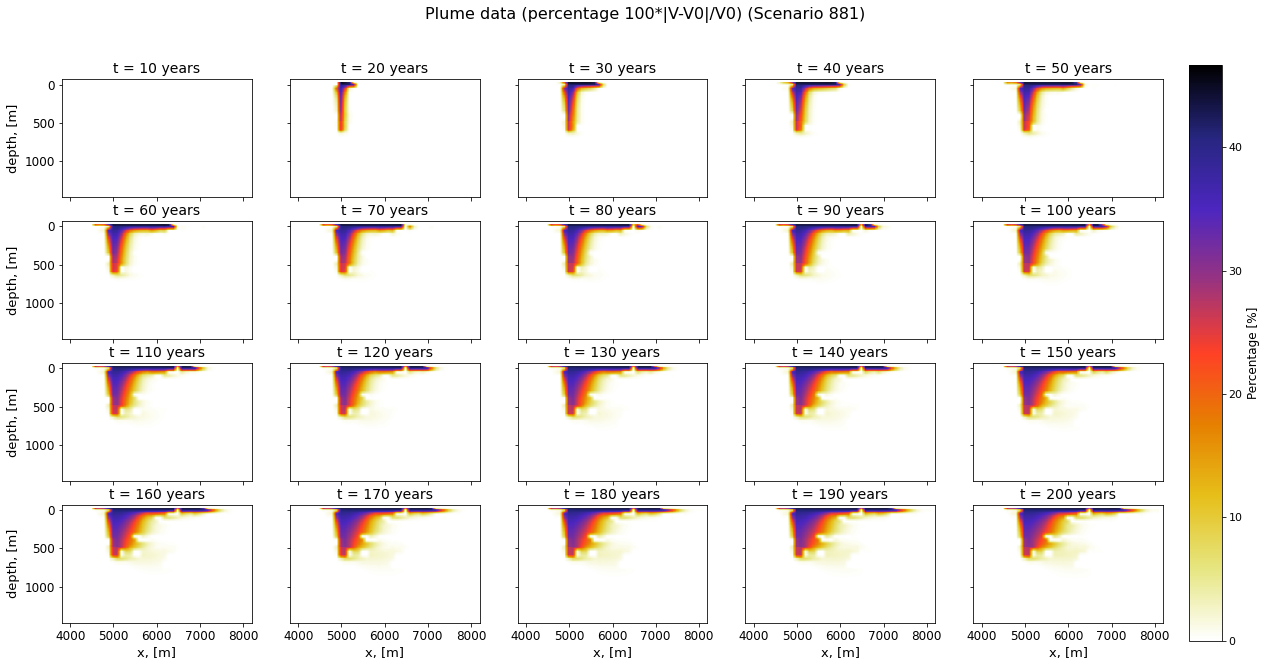

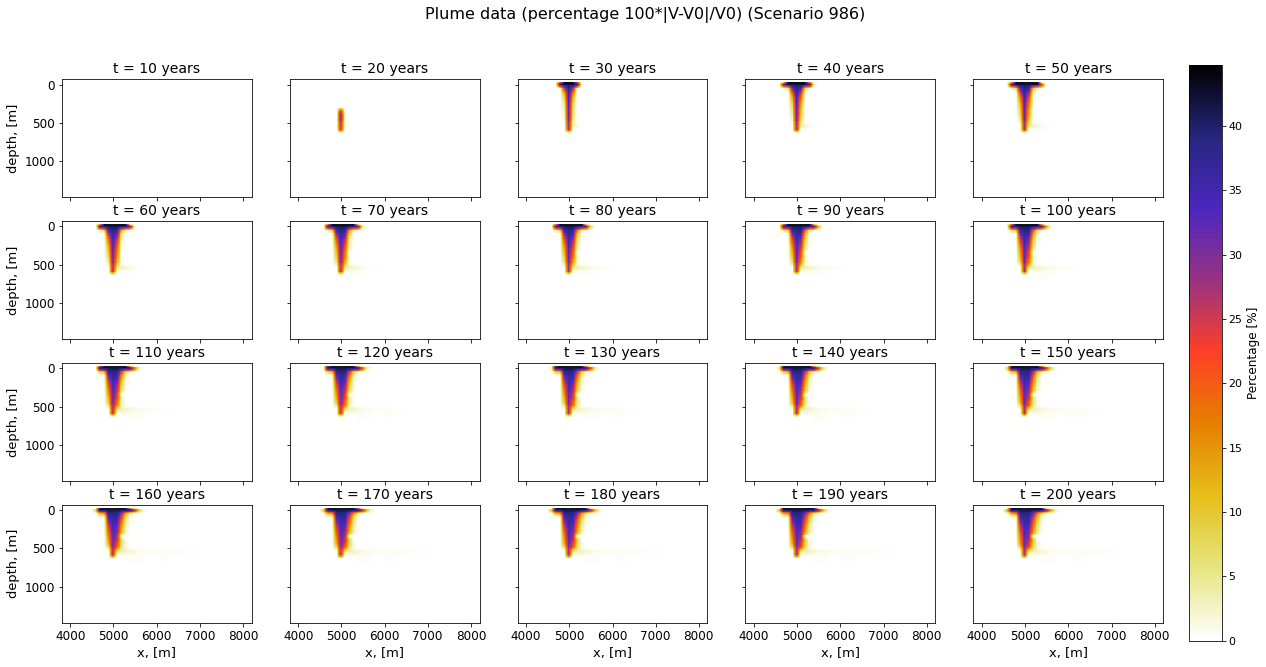

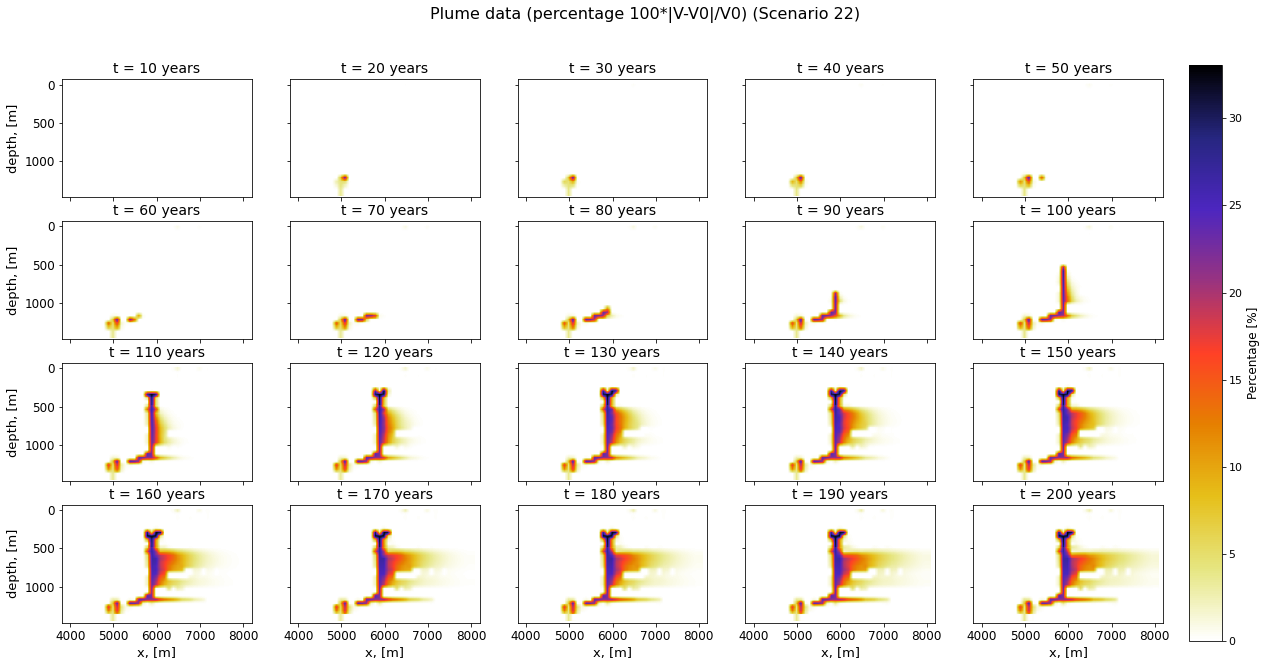

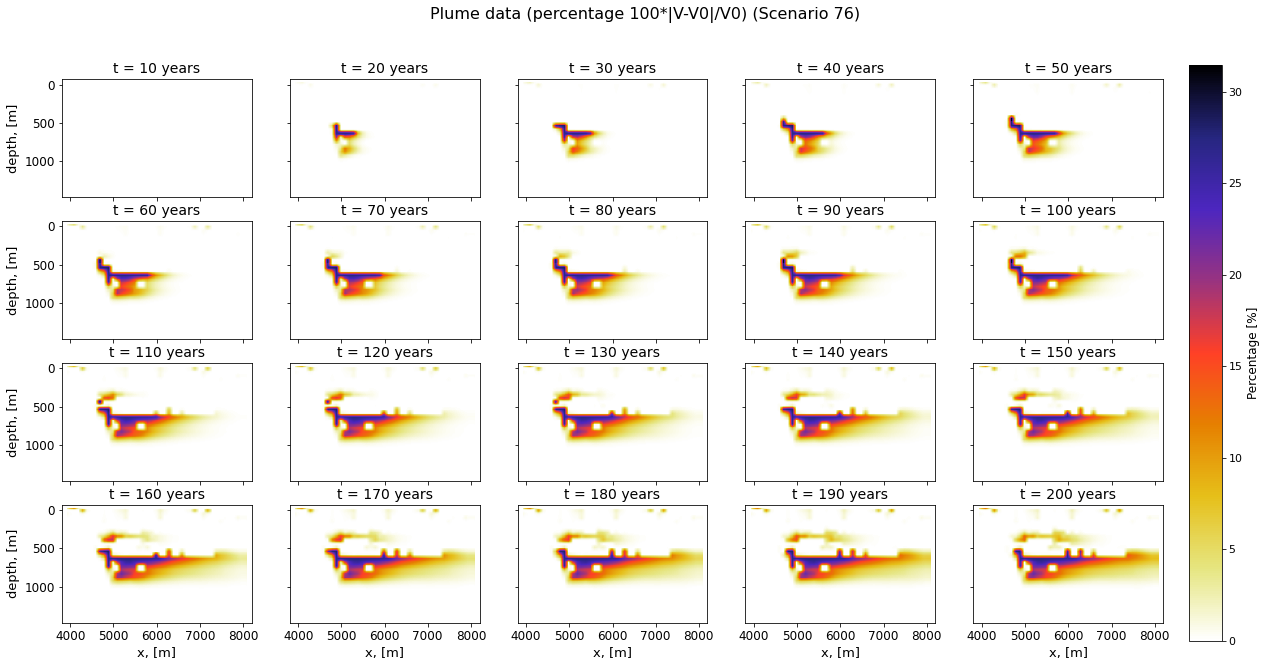

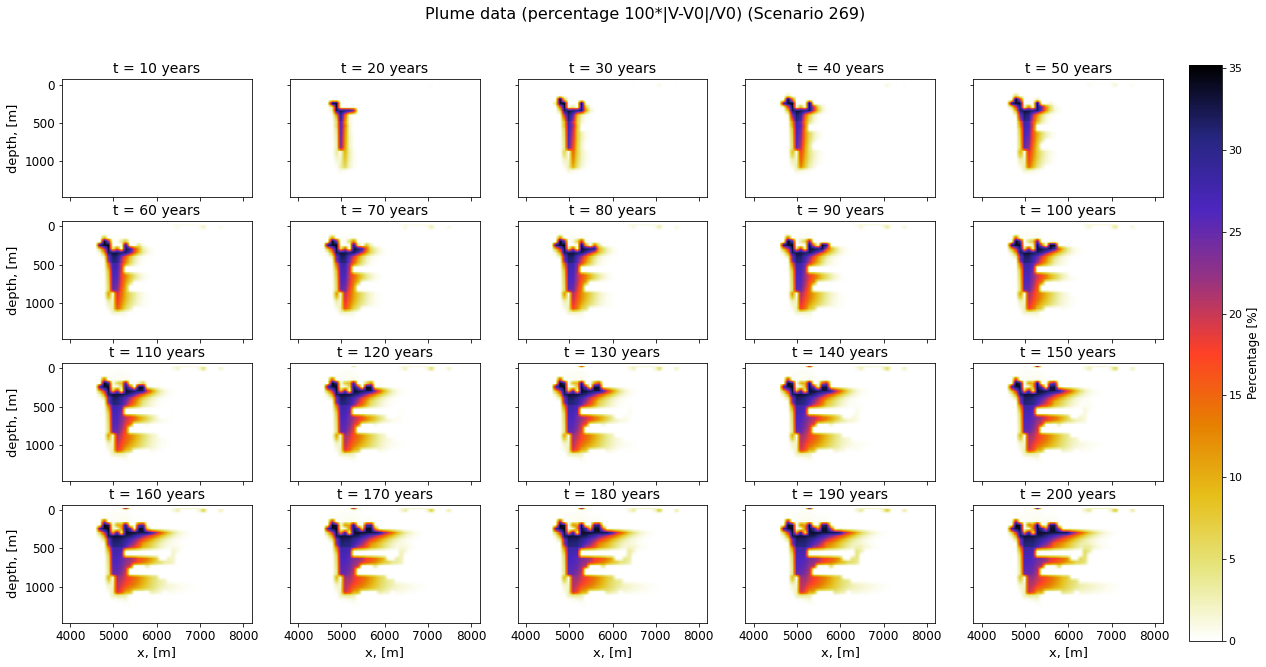

In [13]:
for scen in scenarios:
    fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(18, 10),
                            sharex=True, sharey=True)
    vmin = np.min(plume_data[scen])
    vmax = np.max(plume_data[scen])
    for ind in range(num_time_points):
        row = ind//5
        col = ind%5
        pic = axs[row, col].scatter(xxs, zzs, c=plume_data[scen][ind],
                                    cmap='CMRmap_r', marker='s',
                                    vmin=vmin, vmax=vmax)
        axs[row, col].set_title('t = {} years'.format((ind+1)*10),
                                fontsize=labelsize+2)
        axs[row, col].tick_params(axis='both', which='major',
                                  labelsize=labelsize)
    axs[0, 0].invert_yaxis()
    for row in range(4):
        axs[row, 0].set_ylabel('depth, [m]', fontsize=labelsize+1)
    for col in range(5):
        axs[3, col].set_xlabel('x, [m]', fontsize=labelsize+1)
    fig.suptitle('Plume data (percentage 100*|V-V0|/V0) (Scenario {})'.format(scen),
                 fontsize=labelsize+4)
    fig.subplots_adjust(left=0.05, right=0.9)
    cax = plt.axes([0.92, 0.1, 0.025, 0.8])
    cbar = fig.colorbar(pic, ax=axs, cax=cax)
    cbar.ax.tick_params(labelsize=labelsize-1)
    cbar.set_label(label='Percentage [%]', size=labelsize)

##### Plume boundaries

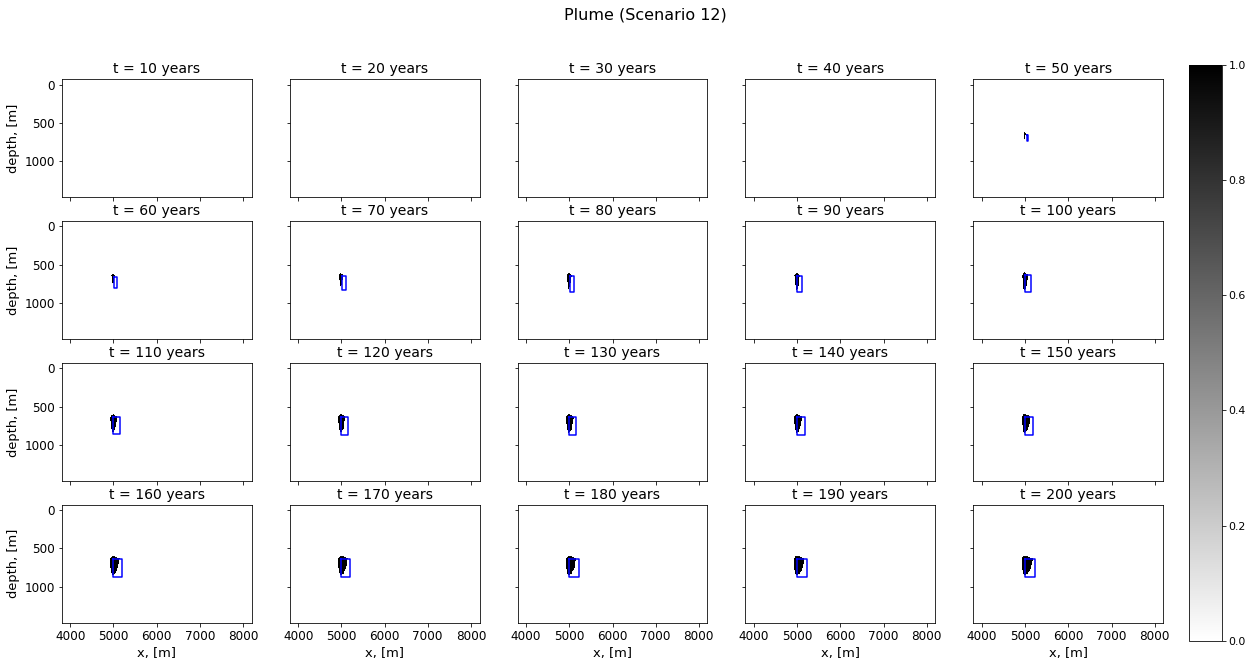

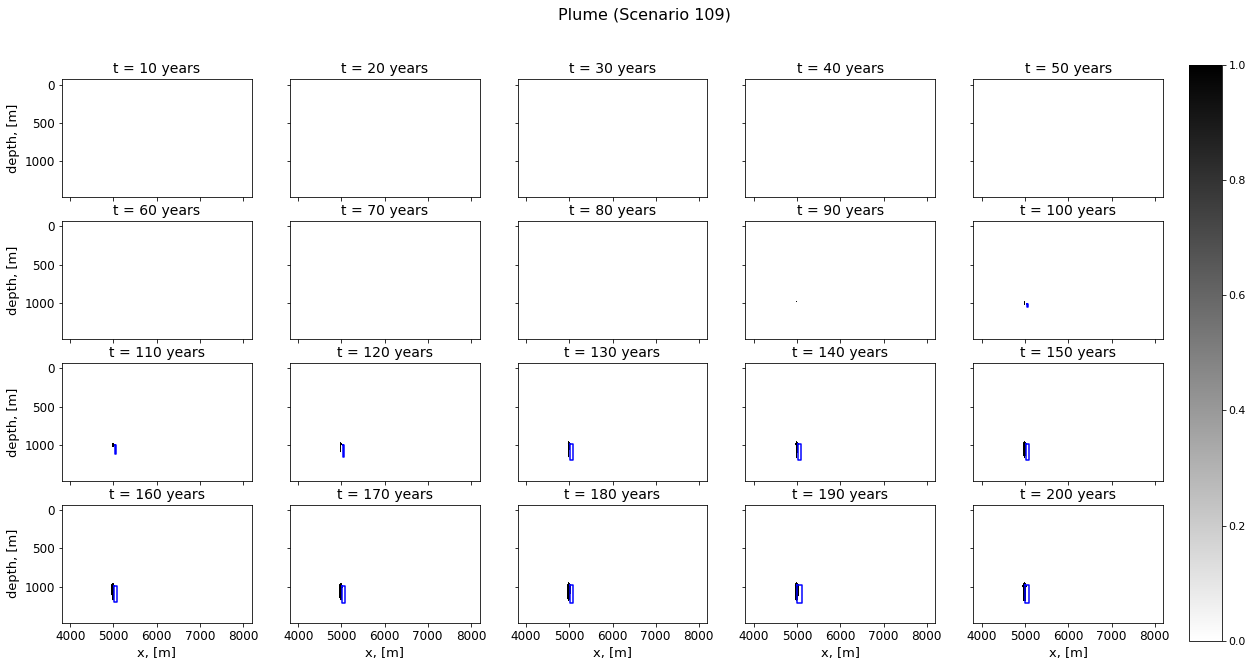

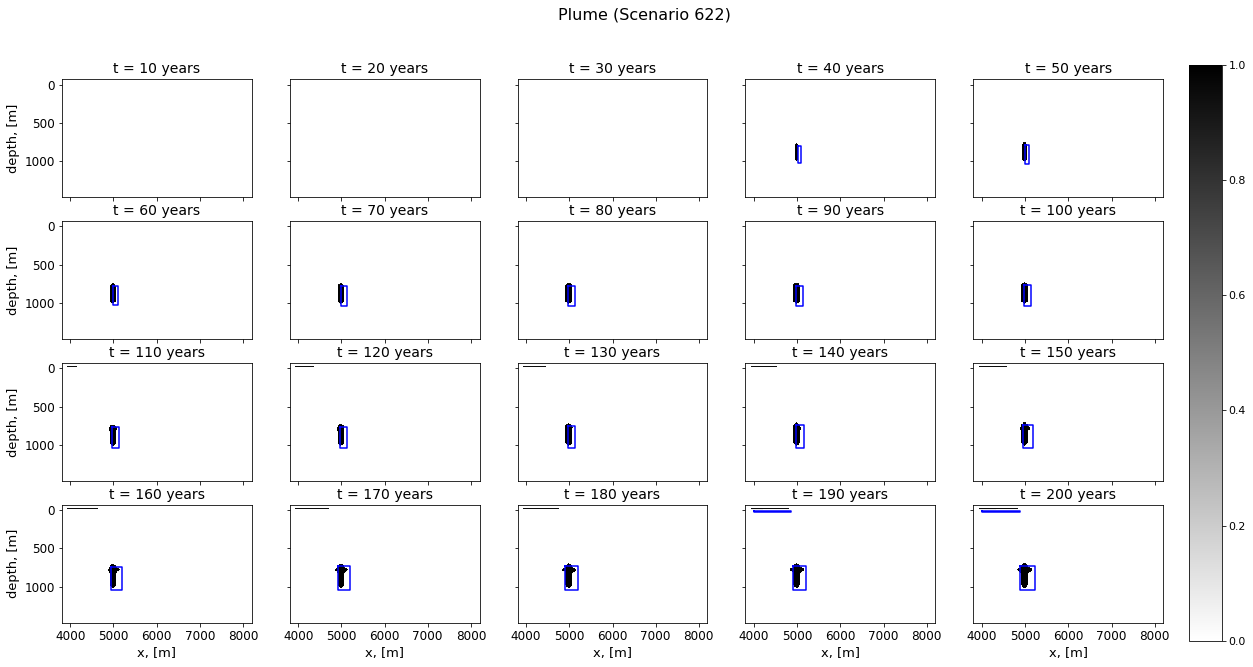

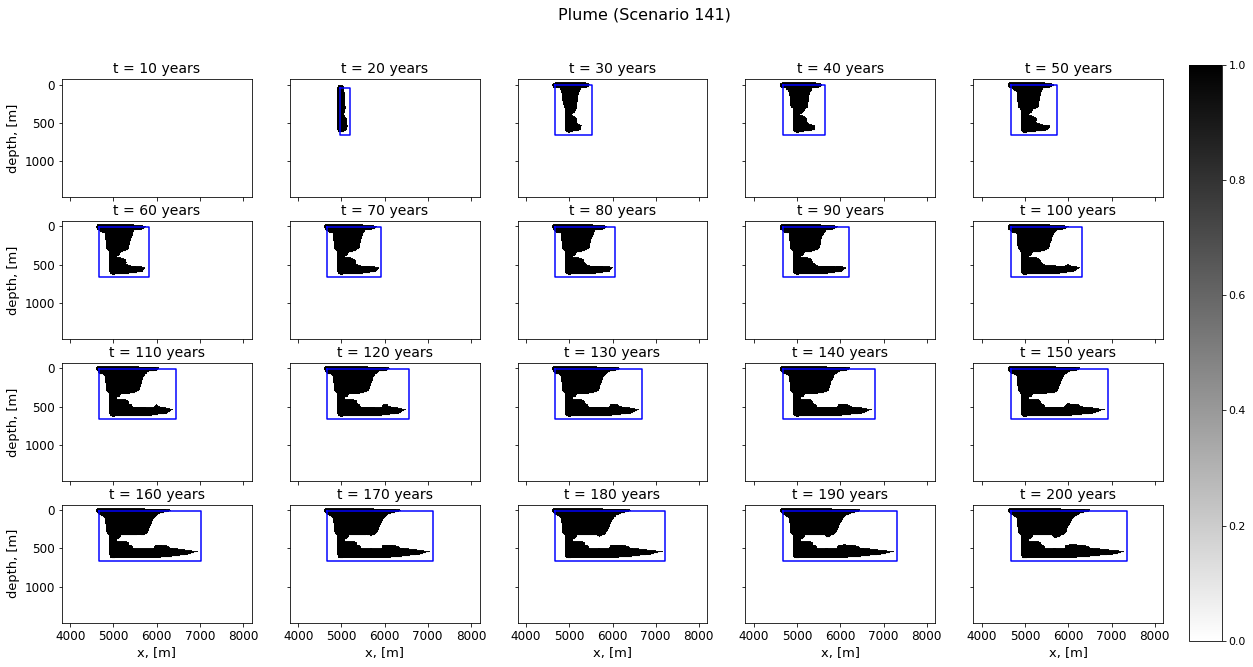

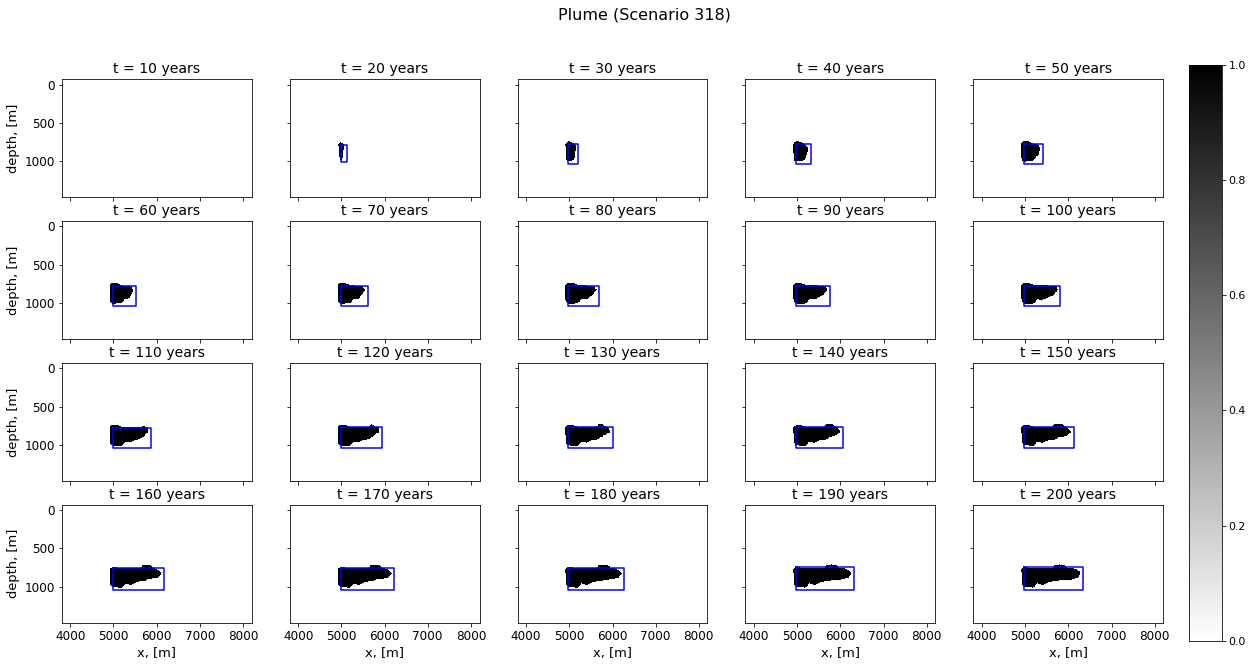

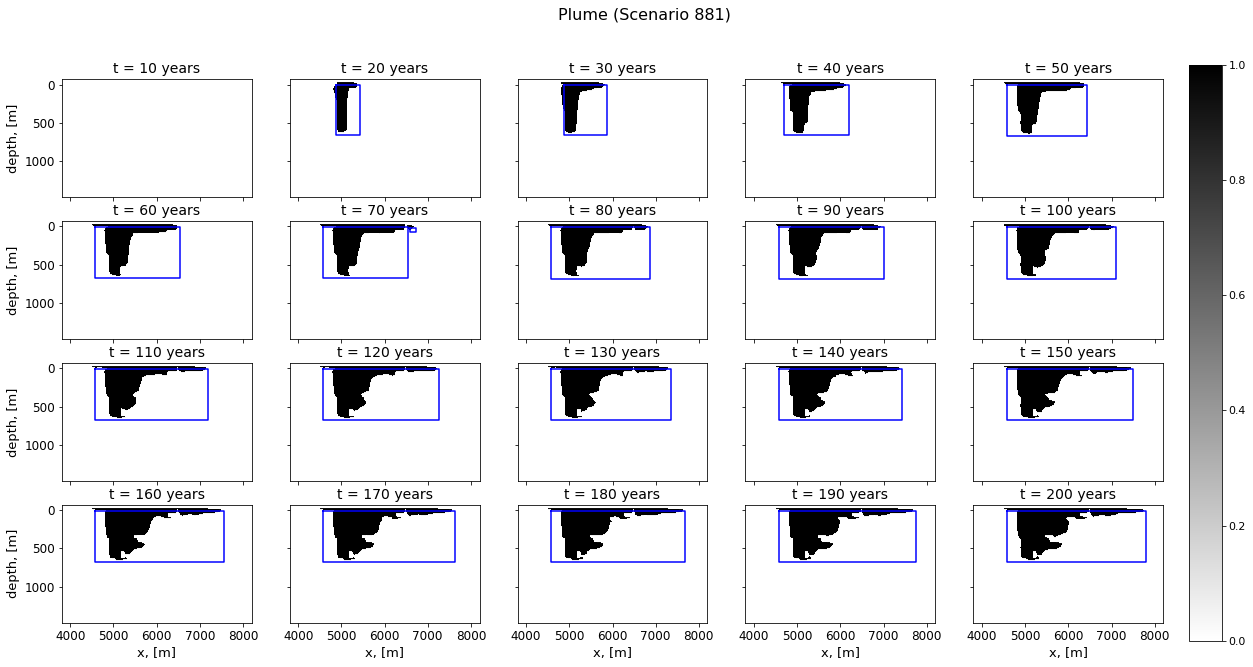

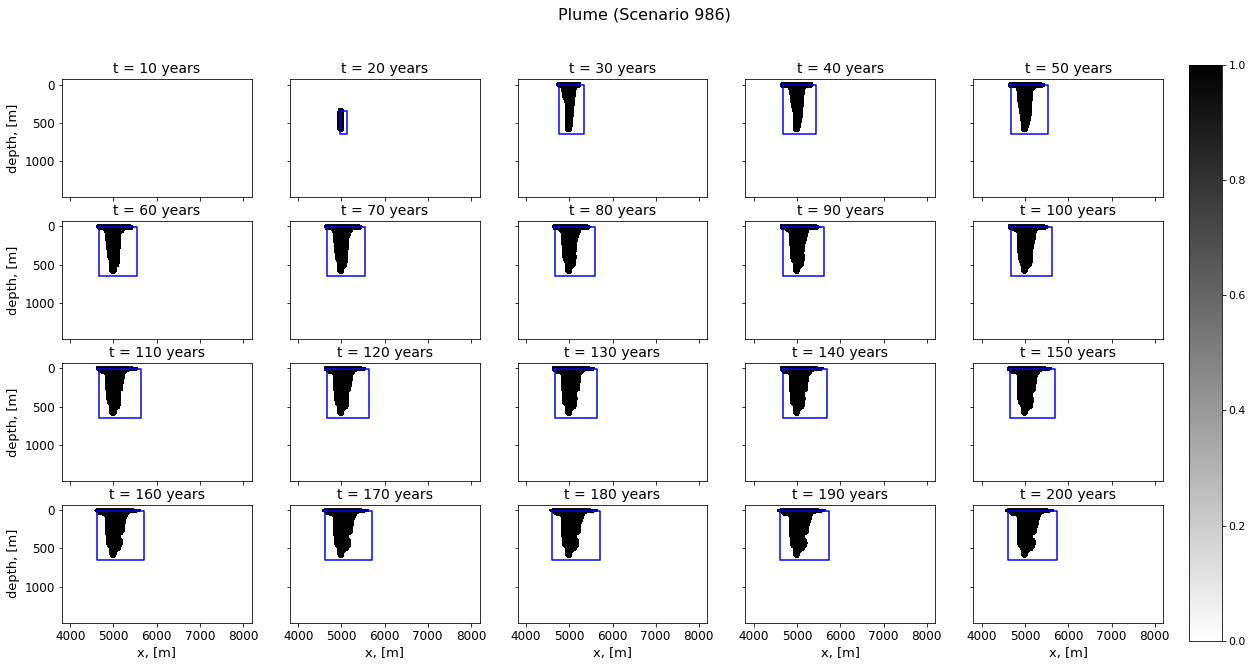

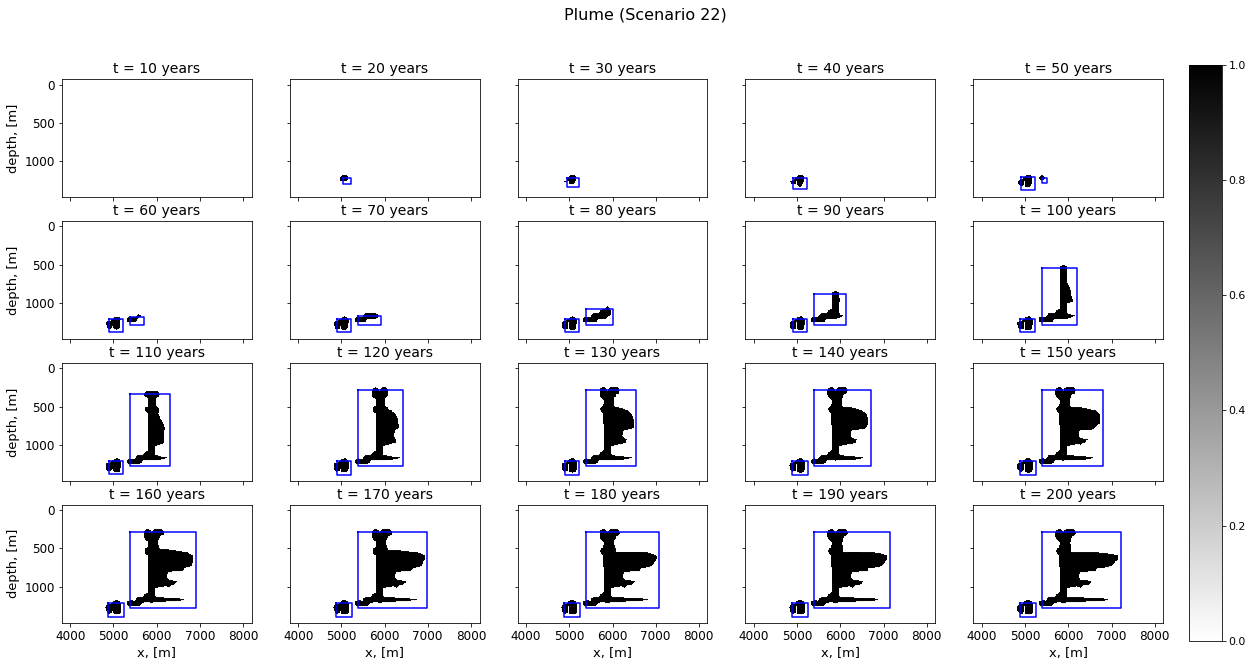

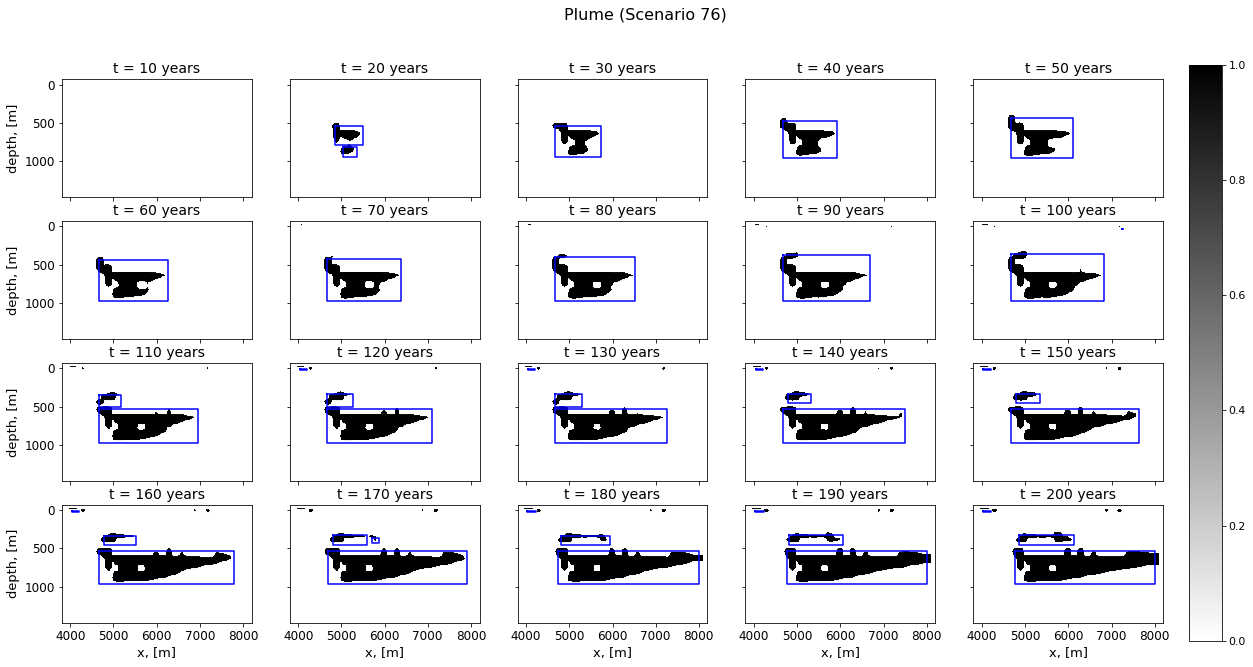

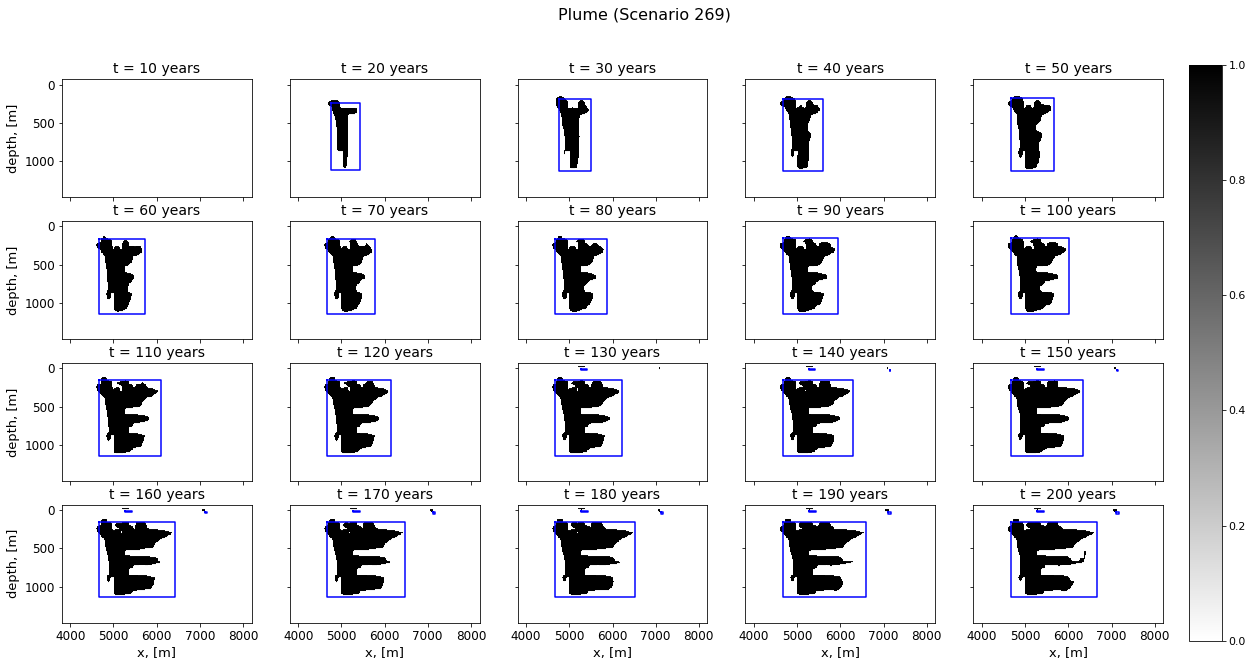

In [14]:
for scen_ind, scen in enumerate(scenarios):
    fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(18, 10),
                            sharex=True, sharey=True)
    for ind in range(num_time_points):
        row = ind//5
        col = ind%5
        pic = axs[row, col].scatter(xxs, zzs, c=plume[scen][ind],
                                    cmap='binary', marker='s',
                                    vmin=0, vmax=1)
        axs[row, col].set_title('t = {} years'.format((ind+1)*10),
                                fontsize=labelsize+2)
        axs[row, col].tick_params(axis='both', which='major',
                                  labelsize=labelsize)
        for plume_ind in range(min(3, out['plest.num_plumes'][scen_ind, ind])):
            if plume_metrics['extent1'][scen][ind][plume_ind]*plume_metrics['extent2'][scen][ind][plume_ind] != 0:
                coord1 = [plume_metrics['min1'][scen][ind][plume_ind],
                          plume_metrics['max1'][scen][ind][plume_ind],
                          plume_metrics['max1'][scen][ind][plume_ind],
                          plume_metrics['min1'][scen][ind][plume_ind],
                          plume_metrics['min1'][scen][ind][plume_ind]]
                coord2 = [plume_metrics['min2'][scen][ind][plume_ind],
                          plume_metrics['min2'][scen][ind][plume_ind],
                          plume_metrics['max2'][scen][ind][plume_ind],
                          plume_metrics['max2'][scen][ind][plume_ind],
                          plume_metrics['min2'][scen][ind][plume_ind]]
                axs[row, col].plot(coord1, coord2, '-b')
    axs[0, 0].invert_yaxis()
    for row in range(4):
        axs[row, 0].set_ylabel('depth, [m]', fontsize=labelsize+1)
    for col in range(5):
        axs[3, col].set_xlabel('x, [m]', fontsize=labelsize+1)
    fig.suptitle('Plume (Scenario {})'.format(scen), fontsize=labelsize+4)
    fig.subplots_adjust(left=0.05, right=0.9)
    cax = plt.axes([0.92, 0.1, 0.025, 0.8])
    cbar = fig.colorbar(pic, ax=axs, cax=cax)
    cbar.ax.tick_params(labelsize=labelsize-1)